<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Introduction to priorityflood component
<hr>

Why we need it [later]

## Example model: performance increase when dealing with 'real' DEMs

### Premise



### Approach

Wrapping the RichDEM package
### Summary

In this notebook we: 

First we will import all the modules we need. 

In [1]:
import sys,time
import numpy as np
import matplotlib.pyplot as plt

from landlab.components import FlowAccumulator,FlowDirAccPf,ChannelProfiler
from landlab.io.netcdf import read_netcdf
from landlab.utils import check_out_dirs,get_watershed_mask
from landlab import imshowhs_grid, imshow_grid
from landlab.io import read_esri_ascii,write_esri_ascii

from bmi_topography import Topography

#Colormaps
cptpath ='/Users/beca4397/Google Drive/GIS_Plotting/getcpt-master'
cpt_path = '/Users/beca4397/Google Drive/GIS_Plotting/getcpt-master/cpt/'        
sys.path.append(cptpath)
import get_cpt

import warnings; warnings.simplefilter('ignore')

Data directories and paths

In [2]:
#%% Save dir
figDir= "/Volumes/E/Data/ModelOutput/FastLab/Figures/RealDEM_demo/"
dataDir= "/Volumes/E/GisData/TOPO_DEMS_demo/"
# SaveDir to save times 
saveDir= figDir + 'storeTimes_demo/'
check_out_dirs(saveDir) 

# save figures
saveFig = True


Create a function to download and save SRTM images using Mark's (aka the coding wizard) BMI_topography. we make a function that uses a buffer around a central coordinate.

In [3]:
def get_topo_buffer(dataDir,buffer,north=40.16,south=40.14,east=-105.49,west=-105.51):
    params = Topography.DEFAULT.copy()
    params["south"] = south -buffer
    params["north"] = north +buffer
    params["west"] = -105.51-buffer
    params["east"] = -105.49+buffer
    params["output_format"] = 'AAIGrid'
    params["cache_dir"] = dataDir
    dem = Topography(**params)
    name = dem.fetch()
    props = dem.load()    
    dim_x = props.sizes['x']
    dim_y = props.sizes['y']
    cells = props.sizes['x']*props.sizes['y']
    grid, z = read_esri_ascii(name, name='topographic__elevation')  
    return dim_x,dim_y,cells,grid, z

Make function to do all kinds of plotting with the landlab grid

In [4]:
def plotting(grid,saveFig,plotDir):
    #%% Plot DEM
    azdeg=200
    altdeg=20
    ve=1
    plt.figure()
    plotType='DEM'            
    ax = imshowhs_grid(grid, "topographic__elevation",grid_units=("deg", "deg"), var_name="Topo, m", cmap='terrain', 
                        plotType=plotType, vertical_exa=ve,azdeg=azdeg,altdeg=altdeg,
                        default_fontsize=12, cbar_tick_size =10,  cbar_width = '100%',
                        cbar_or='vertical',bbox_to_anchor = [1.03,0.3,.075,14], 
                        colorbar_label_y = -15, colorbar_label_x = 0.5, thicks_km =False)

    if saveFig:
        plotDir= figDir + 'Topo/'
        check_out_dirs(plotDir)
        filename = plotDir + 'Sim_' + str(sim_nb) + '_' + '_DEM.jpg'
        plt.savefig(filename, dpi=400)
    plt.pause(0.0001)

    #%% DA D8
    grid.at_node["drainage_area"][grid.at_node["drainage_area"]==0]=grid.dx*grid.dx
    plot_DA=np.log10(grid.at_node["drainage_area"]*111e3*111e3)
    # plot_DA[plot_DA<0]=0
    # plt.figure()
    # imshow_grid(grid, plot_DA,grid_units=("m", "m"), var_name="Elevation (m)", cmap='terrain')

    plt.figure()    
    plotType='Drape1'
    drape1 = plot_DA
    thres_drape1=None
    alpha = 0.5
    myfile1 = 'temperature.cpt'
    cmap1 = get_cpt.get_cmap(cpt_path+myfile1)
    ax=imshowhs_grid(grid, "topographic__elevation",grid_units=("deg", "deg"), cmap=cmap1,
                plotType=plotType,drape1 = drape1,vertical_exa=ve,azdeg=azdeg,altdeg=altdeg,thres_drape1=thres_drape1,alpha=alpha,
                default_fontsize=12, cbar_tick_size =10, var_name="$log^{10}DA, m^2$", cbar_width = '100%',
                cbar_or='vertical',bbox_to_anchor = [1.03,0.3,.075,14], 
                colorbar_label_y = -15, colorbar_label_x = 0.5, thicks_km =False)

    props = dict(boxstyle='round', facecolor='white', alpha=0.6)
    textstr = flow_metric
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    if saveFig:
        plotDir= figDir + 'DA_D8/'
        check_out_dirs(plotDir)            
        filename = plotDir + 'Sim_' + str(sim_nb) + 'DA_Single.jpg'
        plt.savefig(filename, dpi=400)
    plt.pause(0.0001)  

     # %% DA Quinn
    grid.at_node["hill_drainage_area"][grid.at_node["hill_drainage_area"]==0]=grid.dx*grid.dx
    plotDA=np.log10(grid.at_node["hill_drainage_area"]*111e3*111e3)
    # plt.figure()
    # imshow_grid(grid, plotDA,grid_units=("m", "m"), var_name="Elevation (m)", cmap='terrain')

    plt.figure()
    plotType='Drape1'
    # plotType='Drape2'
    drape1 = np.log10(grid.at_node["hill_drainage_area"])
    thres_drape1=None
    alpha = 0.5
    myfile1 = 'temperature.cpt'
    cmap1 = get_cpt.get_cmap(cpt_path+myfile1)
    ax=imshowhs_grid(grid, "topographic__elevation",grid_units=("deg", "deg"), cmap=cmap1,
                plotType=plotType,drape1 = drape1,vertical_exa=ve,azdeg=azdeg,altdeg=altdeg,thres_drape1=thres_drape1,alpha=alpha,
                default_fontsize=10, cbar_tick_size =10, var_name="$log^{10}DA, m^2$", cbar_width = '100%',
                cbar_or='vertical',bbox_to_anchor = [1.03,0.3,.075,14], 
                colorbar_label_y = -15, colorbar_label_x = 0.5, thicks_km =False)

    props = dict(boxstyle='round', facecolor='white', alpha=0.6)
    textstr = hill_flow_metric
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    if saveFig:
        plotDir= figDir + 'DA_Quinn/'
        check_out_dirs(plotDir)            
        filename = plotDir + 'Sim_' + str(sim_nb) + '_' + '_DA_Multi.jpg'
        plt.savefig(filename, dpi=400)
    plt.pause(0.0001)  

    #%% River planform
    # Extract the largest channel draining to the largest outlet node on 
    # the model grid boundary traced back all the way to the watershed divide.
    profiler = ChannelProfiler(grid,number_of_watersheds=1)
    profiler.run_one_step()

    # % Now, lets plot a river on top of this 
    profiler = ChannelProfiler(grid)
    profiler.run_one_step()

    #%% Extract biggest watershed        

    # Get the watershed from the outlet to the divide 
    loc=profiler.nodes[0][0]
    mask= get_watershed_mask(grid, loc)

    plt.figure()

    plotType='Drape1'
    # plotType='Drape2'
    drape1 = mask
    thres_drape1=.1
    alpha = 0.5
    myfile1 = 'temperature.cpt'
    cmap1 = get_cpt.get_cmap(cpt_path+myfile1)
    ax=imshowhs_grid(grid, "topographic__elevation",grid_units=("deg", "deg"), cmap=cmap1,
                plotType=plotType,drape1 = drape1,vertical_exa=ve,azdeg=azdeg,altdeg=altdeg,thres_drape1=thres_drape1,alpha=alpha,
                default_fontsize=10,allow_colorbar=False, thicks_km =False)


    # Add river on top 
    riv_nodes = profiler.nodes
    riv_x = grid.x_of_node[riv_nodes]
    riv_y = grid.y_of_node[riv_nodes]
    ax.plot(riv_x,riv_y,color=[0.1,0.1,0.7],linewidth=3)

    if saveFig:
        plotDir= figDir + 'Watershed/'
        check_out_dirs(plotDir)            
        filename = plotDir + 'Sim_' + str(sim_nb) + '_' + '_Watershed.jpg'
        plt.savefig(filename, dpi=400)
    plt.pause(0.0001) 


    #%% Plot river profile
    el_atNodes=grid.at_node["topographic__elevation"]
    dist_atNodes=profiler.distance_along_profile
    dist_atNodes = dist_atNodes[0]   
    el = grid.at_node["topographic__elevation"][riv_nodes]
    da = grid.at_node["drainage_area"][riv_nodes]*111000*111000
    da_hill = grid.at_node["hill_drainage_area"][riv_nodes]*111000*111000
    plt_fontsize =14

    fig, ax1 = plt.subplots()#figsize=(3,2)
    ax2 = ax1.twinx()
    dist = (max(dist_atNodes)-dist_atNodes)*111
    lns1 =  ax1.plot(dist,el,color='k',label='topo',linewidth=1.5)
    lns2 =  ax2.plot(dist,da,color='b',label='DA_D8',linewidth=1.5)
    lns2 =  ax2.plot(dist,da_hill,color='g',ls='--', label='DA_Quinn',linewidth=1.5)

    ax1.set_xlabel('Distance Along Profile, km',fontsize=plt_fontsize)
    ax1.tick_params(labelsize=plt_fontsize )
    ax1.set_ylabel('Elevation, m',fontsize=plt_fontsize)            
    ax2.set_ylabel('Drainage Area, $m^2$',fontsize=plt_fontsize)     
    ax2.tick_params(labelsize=plt_fontsize )
    ax1.xaxis.offsetText.set_fontsize(plt_fontsize)
    ax2.yaxis.offsetText.set_fontsize(plt_fontsize)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, fontsize=plt_fontsize,loc='upper center')

    if saveFig:
        plotDir= figDir + 'RiverProfile/'
        check_out_dirs(plotDir)            
        filename = plotDir + 'Sim_' + str(sim_nb) + '_' + '_RiverProfile.jpg'
        plt.savefig(filename, dpi=400)
    plt.pause(0.0001) 

Create an array of `n` buffer sizes. Each `n`<sup>th</sup> element of the array is representing the degrees by which the size of the DEM will be increasing. 

In [5]:
deg_inc=np.logspace(-.8,-.4,5)

## Run the model for default flow director/accumualtor vs Priority flood 

The model will be run over the `n` iterations. <br>
Store model properties in arrays of dimension `n`.  <br>
Run the model for all the `n` buffers. <br>

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


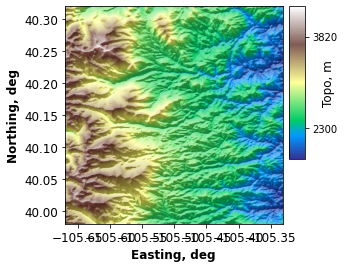

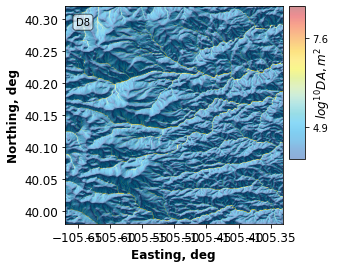

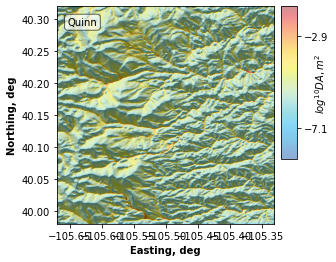

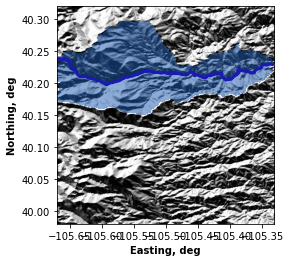

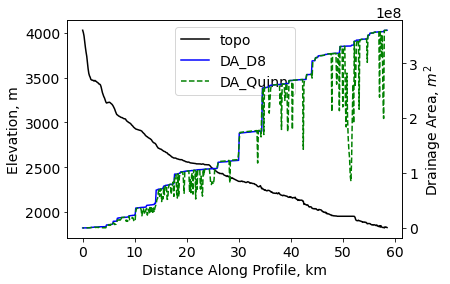

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


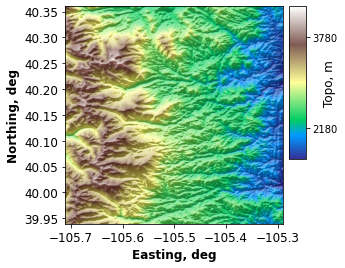

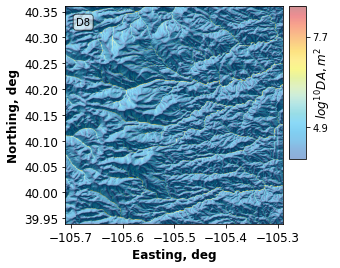

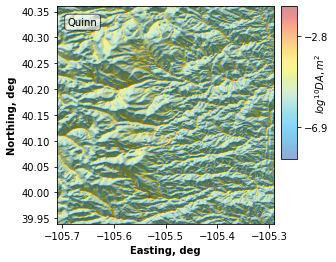

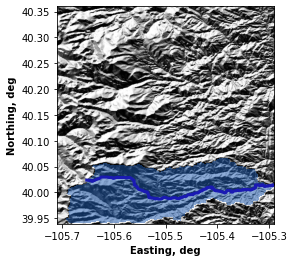

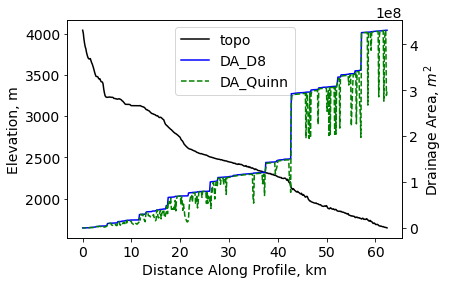

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


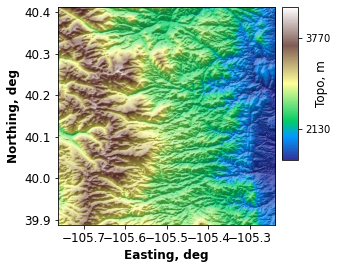

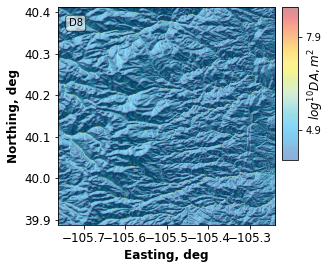

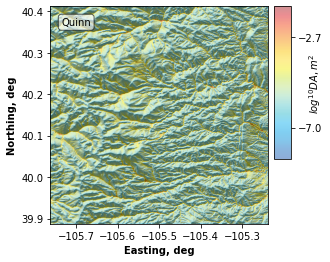

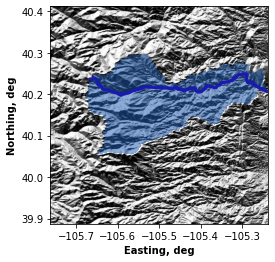

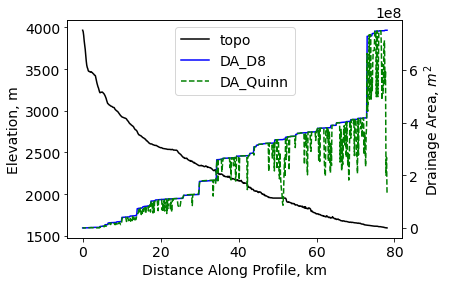

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


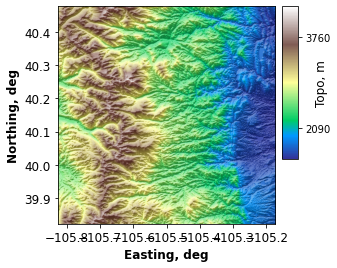

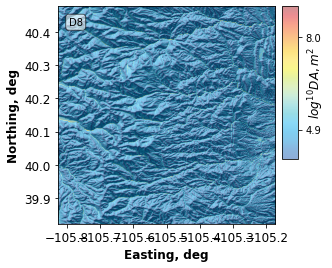

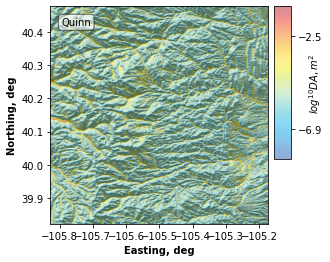

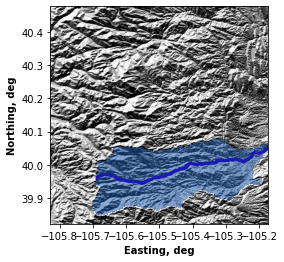

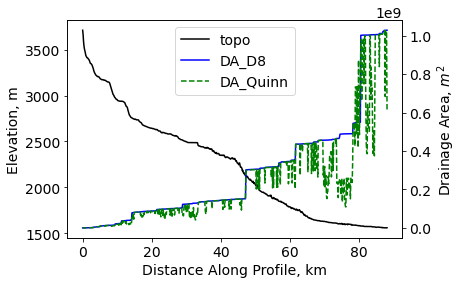

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


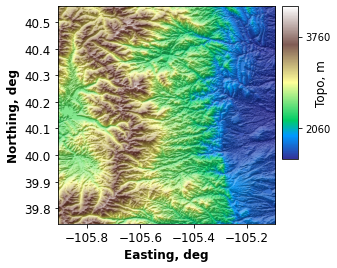

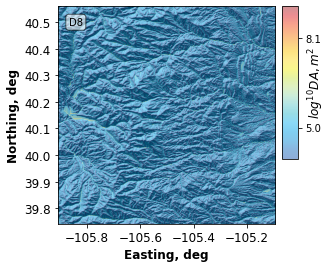

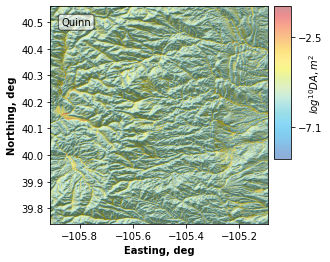

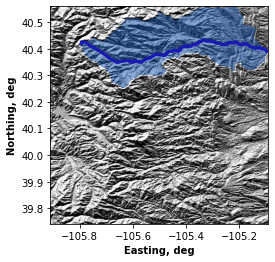

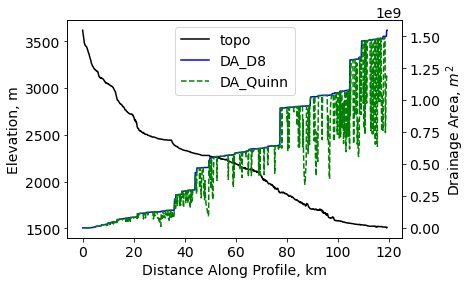

In [6]:
dim_x = np.zeros_like(deg_inc)
dim_y = np.zeros_like(deg_inc)
cells = np.zeros_like(deg_inc)
timeSpent_LL = np.zeros_like(deg_inc)
timeSpent_PF = np.zeros_like(deg_inc)
for sim_nb in np.arange(0,len(deg_inc)):
    #Download or reload topo data with given buffer
    dim_x[sim_nb],dim_y[sim_nb],cells[sim_nb],grid_LL,z_LL= \
        get_topo_buffer(dataDir,deg_inc[sim_nb])
    # 1. Performance default flow director/accumualtor 
    fa_LL = FlowAccumulator(grid_LL, flow_director='D8',depression_finder='DepressionFinderAndRouter')
    fa_LL.run_one_step()
    t = time.time()
    fa_LL.run_one_step()
    elapsed = time.time() - t
    timeSpent_LL[sim_nb] = elapsed
    
    # 2. Performance Priority flow director/accumualtor 
    #Download or reload topo data with given buffer
    dim_x[sim_nb],dim_y[sim_nb],cells[sim_nb],grid_PF,z= \
        get_topo_buffer(dataDir,deg_inc[sim_nb])
    # For timing compare only single flow
    flow_metric = 'D8'
    hill_flow_metric = 'Quinn'
    fa_PF = FlowDirAccPf(grid_PF, 
                      surface="topographic__elevation", 
                      flow_metric = flow_metric,
                      suppress_out=False,
                      depressionHandler ='fill',
                      accumulateFlow = True, 
                      seperate_Hill_Flow= True,
                      accumulateFlowHill = True,                  
                      update_HillFlow_instanteneous = False,
                      hill_flow_metric= hill_flow_metric)
    t = time.time()
    fa_PF.run_one_step()
    # fa.update_Hill_FDFA(updateDepressions=False)
    elapsed = time.time() - t
    timeSpent_PF[sim_nb] = elapsed
    # After timing, also update multiple flow over hillslopes. 
    # Note that this info is also stored in the same PriorityFlood object.
    fa_PF.update_Hill_FDFA(updateDepressions =False)
    
    #3. Plot output products
    plotting(grid_PF,saveFig,figDir)
    

np.save(saveDir + 'LL' +'_timeSpent_demo.npy', timeSpent_LL)
np.save(saveDir + 'PF' +'_timeSpent_demo.npy', timeSpent_PF)
np.save(saveDir + 'cells_demo.npy', cells)
    

Plot performance

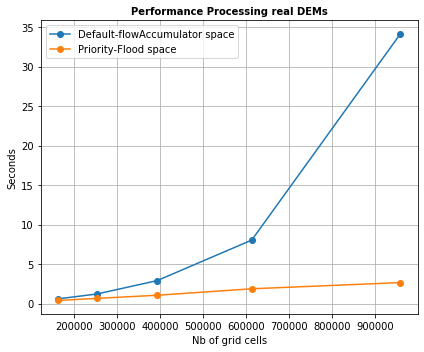

In [7]:
# %% Display grid
timeSpent_LL = np.load(saveDir + 'LL_timeSpent_demo.npy')
timeSpent_PF = np.load(saveDir + 'PF_timeSpent_demo.npy')

plt.figure(figsize=(6,5))
plt.grid(True, which="both")
plt_fontsize =10

plt.plot(cells,timeSpent_LL ,label='Default-flowAccumulator space',marker="o")
plt.plot(cells,timeSpent_PF,label='Priority-Flood space',marker="o")

plt.title('Performance Processing real DEMs', fontsize=plt_fontsize, fontweight='bold')
plt.xlabel('Nb of grid cells', fontsize=plt_fontsize) 
plt.ylabel('Seconds', fontsize=plt_fontsize)
plt.legend(loc='upper left', fontsize=plt_fontsize)
plt.tick_params(labelsize=plt_fontsize )
plt.tight_layout()

if saveFig: 
    plotDir= figDir + 'Performance/'
    check_out_dirs(plotDir) 
    plt.savefig(plotDir+ 'RealTopo_Perf_Default_FA_vs_PF_Linear_demo.png',dpi=300)
plt.show()

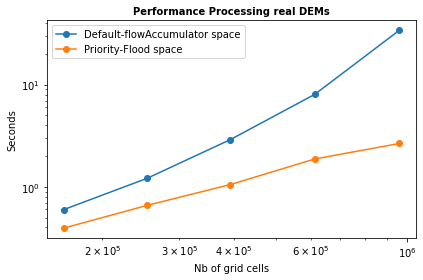

In [8]:
# %% Display grid
plt.plot(cells,timeSpent_LL ,label='Default-flowAccumulator space',marker="o")
plt.plot(cells,timeSpent_PF,label='Priority-Flood space',marker="o")
plt.yscale('log')
plt.xscale('log')

plt.title('Performance Processing real DEMs', fontsize=plt_fontsize, fontweight='bold')
plt.xlabel('Nb of grid cells', fontsize=plt_fontsize) 
plt.ylabel('Seconds', fontsize=plt_fontsize)
plt.legend(loc='upper left', fontsize=plt_fontsize)
plt.tick_params(labelsize=plt_fontsize )
plt.tight_layout()

if saveFig: 
    plotDir= figDir + 'Performance/'
    check_out_dirs(plotDir) 
    plt.savefig(plotDir+ 'RealTopo_Perf_Default_FA_vs_PF_log_demo.png',dpi=300)
plt.show()